# FomulaBEAT

中置記法からポーランド記法へ変換するタスク

4-1-5からの変更点
- タスクを中置記法からポーランド記法に変換するタスクに変更
- データを空白を削除したもの、さらに深さは0-4（03-7）で層ごとのサイズを同数に
- 次元を16次元にする
- lossやAccuracyなどの可視化



In [1]:
version = '04-2-3'
model_dir = './model/' + version
data_path = 'data/eq03-7.txt'
test_data_path = 'data/eq03-7-test.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['9*8', '3', '4*1+4+9*2'] ['*98', '3', '+*41+4*92']


辞書データの作成

In [7]:
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '*': 10, '+': 11, '<start>': 12, '<end>': 13, '<pad>': 14, '<unk>': 15}


In [9]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[12, 11, 15, 11, 15, 1, 15, 5, 15, 11, 15, 8, 15, 5, 13]

In [10]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  8, 11,  3, 11,  8, 11,  1, 10,  4, 11,  3, 13])
Output: tensor([12, 11,  8, 11,  3, 11,  8, 11, 10,  1,  4,  3, 13])
元に戻した文章
Input: 8+3+8+1*4+3
Output: +8+3+8+*143


In [11]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [12]:
len(train_data)

800000

Transoformerの設定

In [13]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [14]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [15]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [16]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [17]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [18]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [19]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 16
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [20]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 16, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)


In [21]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


13 層

層名: token_embedding.embedding.weight
形状: torch.Size([16, 16])
値: Parameter containing:
tensor([[-1.2439e-02, -4.1178e-01,  1.2398e-01, -1.0034e-01,  2.4014e-02, -1.5690e-02,  5.8946e-02,
         -1.5592e-01, -3.0794e-01,  1.6218e-01, -1.2007e-01, -1.2879e-01,  2.6522e-01, -3.8936e-01,
          3.3131e-01, -1.4922e-01],
        [-2.9036e-01, -2.4352e-01, -2.1988e-01, -1.5351e-01,  1.8931e-01, -3.1479e-01, -4.1298e-01,
         -3.3346e-01, -2.4665e-01, -5.8057e-02,  4.0664e-01, -3.3320e-01,  2.8756e-02, -3.4472e-01,
          1.1565e-01, -2.6839e-01],
        [-2.3803e-01, -3.4416e-01, -9.8973e-02, -2.8952e-01, -4.9961e-02, -2.9902e-01, -1.9335e-01,
         -4.2187e-01, -3.4412e-01,  3.3048e-02,  3.8596e-02,  2.9667e-01,  2.0332e-01, -5.7871e-02,
          4.0948e-01, -1.3143e-01],
        [ 3.7486e-01, -2.5301e-01, -1.2893e-01, -9.3580e-02,  1.9729e-02, -3.1890e-01, -5.1166e-02,
          9.1391e-02, -1.7519e-01,  7.8454e-02, -1.2903e-01,  1.9796e-01,  4.1683e-01, -2.0353e-01,

## 学習実行

In [22]:
epoch = 20
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

# 可視化用に保存
train_losses = []
valid_losses = []

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    print('[{}/{}] train loss: {:.4f}, valid loss: {:.4f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    counter += 1
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    

  0%|          | 0/782 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 782/782 [00:11<00:00, 65.57it/s]


[1/20] train loss: 1.3450, valid loss: 0.5558  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 66.43it/s]


[2/20] train loss: 0.3304, valid loss: 0.2044  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 66.50it/s]


[3/20] train loss: 0.1468, valid loss: 0.1036  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.01it/s]


[4/20] train loss: 0.0893, valid loss: 0.0691  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 66.82it/s]


[5/20] train loss: 0.0656, valid loss: 0.0514  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 66.73it/s]


[6/20] train loss: 0.0598, valid loss: 0.0434  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.02it/s]


[7/20] train loss: 0.0380, valid loss: 0.0345  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.19it/s]


[8/20] train loss: 0.0310, valid loss: 0.0259  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 66.51it/s]


[9/20] train loss: 0.0571, valid loss: 0.0195  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 66.35it/s]


[10/20] train loss: 0.0321, valid loss: 0.0251  [12s] counter: 0 


100%|██████████| 782/782 [00:11<00:00, 66.73it/s]


[11/20] train loss: 0.0176, valid loss: 0.0152  [12s] counter: 1 **


100%|██████████| 782/782 [00:11<00:00, 67.19it/s]


[12/20] train loss: 0.0112, valid loss: 0.0083  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.20it/s]


[13/20] train loss: 0.0273, valid loss: 0.0088  [12s] counter: 0 


100%|██████████| 782/782 [00:11<00:00, 67.21it/s]


[14/20] train loss: 0.0072, valid loss: 0.0063  [12s] counter: 1 **


100%|██████████| 782/782 [00:11<00:00, 67.09it/s]


[15/20] train loss: 0.0151, valid loss: 0.0069  [12s] counter: 0 


100%|██████████| 782/782 [00:11<00:00, 67.24it/s]


[16/20] train loss: 0.0058, valid loss: 0.0055  [12s] counter: 1 **


100%|██████████| 782/782 [00:11<00:00, 67.02it/s]


[17/20] train loss: 0.0234, valid loss: 0.0069  [12s] counter: 0 


100%|██████████| 782/782 [00:11<00:00, 66.92it/s]


[18/20] train loss: 0.0055, valid loss: 0.0048  [12s] counter: 1 **


100%|██████████| 782/782 [00:11<00:00, 67.29it/s]


[19/20] train loss: 0.0080, valid loss: 0.0067  [12s] counter: 0 


100%|██████████| 782/782 [00:11<00:00, 66.98it/s]


[20/20] train loss: 0.0046, valid loss: 0.0038  [12s] counter: 1 **


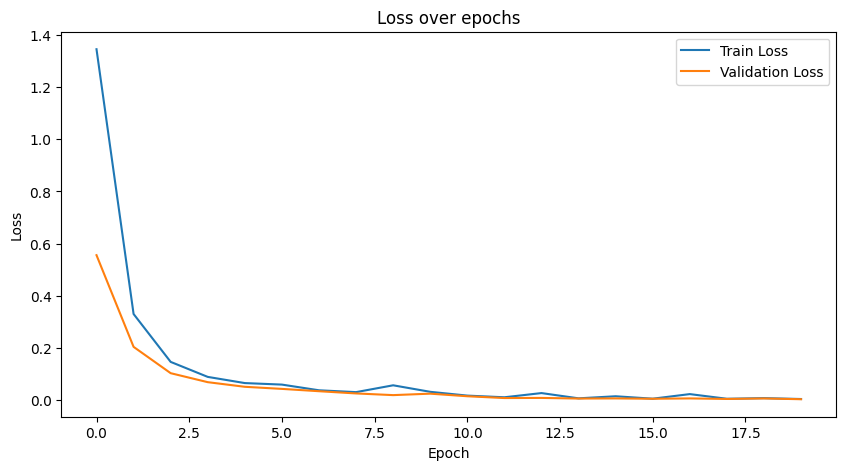

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

学習したモデルの保存

In [24]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [25]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.compute_output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [27]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

# 翻訳を実行
translation = translate(
    model=loaded_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: ++15+85
Output: +1+15


In [39]:
# 様々な入力を試してみる

text_list = {
"0*0" : "*00",
"6+9" : "+69",
"4+7+5" : "+4+75",
"7+7*0*8*4+2*9" : "+7+*7*0*84*29",
"0+6" : "+06",
"7+6+6+2" : "+7+6+62",
"2+9+1+0*9+8*0" : "+2+9+1+*09*80",
"1" : "1",
"9*5*3*7" : "*9*5*37",
"2+3*0" : "+2*30",
"3*7+5*0" : "+*37*50",
"5*3*7*9+1+8+2+9" : "+*5*3*79+1+8+29"
}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=loaded_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input  : {text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt}")
    print('---')


Input  : 0*0
Output : *00
Correct: *00
---
Input  : 6+9
Output : +69
Correct: +69
---
Input  : 4+7+5
Output : +4+75
Correct: +4+75
---
Input  : 7+7*0*8*4+2*9
Output : +7+*7*0*84*29
Correct: +7+*7*0*84*29
---
Input  : 0+6
Output : +06
Correct: +06
---
Input  : 7+6+6+2
Output : +7+6+62
Correct: +7+6+62
---
Input  : 2+9+1+0*9+8*0
Output : +2+9+1+*09*80
Correct: +2+9+1+*09*80
---
Input  : 1
Output : 1
Correct: 1
---
Input  : 9*5*3*7
Output : *9*5*37
Correct: *9*5*37
---
Input  : 2+3*0
Output : +2*30
Correct: +2*30
---
Input  : 3*7+5*0
Output : +*37*50
Correct: +*37*50
---
Input  : 5*3*7*9+1+8+2+9
Output : +*5*3*79+1+8+29
Correct: +*5*3*79+1+8+29
---


In [29]:
# テスト用ファイルの読み込み関数
def read_test_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    test_data = []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        test_data.append((src, tgt))
    return test_data

# 正答率を計算する関数
def calculate_accuracy(model, test_data, vocab_src, vocab_tgt, seq_len_tgt, START_IDX, END_IDX):
    correct = 0
    total = len(test_data)
    mistakes = []

    for src_text, tgt_text in test_data:
        # モデルを使って翻訳を実行
        translation = translate(
            model=model, text=src_text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
            seq_len_tgt=seq_len_tgt,
            START_IDX=START_IDX, END_IDX=END_IDX
        )

        # 正答のチェック
        if translation == tgt_text:
            correct += 1
        else:
            # 間違えたものを保存
            mistakes.append((src_text, translation, tgt_text))

    accuracy = correct / total * 100
    return accuracy, mistakes


# テストデータの読み込み
test_data = read_test_file(test_data_path)

# 正答率の計算（間違いの詳細も取得）
accuracy, mistakes = calculate_accuracy(
    model=loaded_model, test_data=test_data,
    vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

# 正答率の表示
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Mistakes: {len(mistakes)} out of {len(test_data)}")

# 間違えたケースの一部（10件まで）を表示
print("\nExamples of mistakes:")
for i, (src_text, translation, tgt_text) in enumerate(mistakes[:10]):
    print(f"Input  : {src_text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt_text}")
    print('---')


Test Accuracy: 99.20%
Mistakes: 16 out of 2000

Examples of mistakes:
Input  : 9+6*9*5*5*6+7
Output : +9*6*9*5*5*67
Correct: +9+*6*9*5*567
---
Input  : 8*5+8*0+1*9+2+2
Output : +*85+*80+*192+2
Correct: +*85+*80+*19+22
---
Input  : 4+1+5+9*5*5*8+3
Output : +4+1+5*9*5*583
Correct: +4+1+5+*9*5*583
---
Input  : 5+4+8*4*0*1*9+2
Output : +5+4*8*4*0*192
Correct: +5+4+*8*4*0*192
---
Input  : 0*4+0*8*9*3+1
Output : +*04*0*8*9*31
Correct: +*04+*0*8*931
---
Input  : 6+8+1+3*1*2*4+4
Output : +6+8+1*3*1*244
Correct: +6+8+1+*3*1*244
---
Input  : 9*7+9*9*5*3+3
Output : +*97*9+*9*533
Correct: +*97+*9*9*533
---
Input  : 6+0+6*7*8*3+2
Output : +6+0*6*7*8*32
Correct: +6+0+*6*7*832
---
Input  : 5+2*4*7+1*8*3+3
Output : +5+*2*47+*18*33
Correct: +5+*2*47+*1*833
---
Input  : 2+1+8*4*8*3*1+0
Output : +2+1*8*4*8*311
Correct: +2+1+*8*4*8*310
---


## モデルの動作を分析

In [30]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 16, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)

In [31]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([16, 16])
decoder_layer.self_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.self_attn.in_proj_bias torch.Size([48])
decoder_layer.self_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.self_attn.out_proj.bias torch.Size([16])
decoder_layer.multihead_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.multihead_attn.in_proj_bias torch.Size([48])
decoder_layer.multihead_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.multihead_attn.out_proj.bias torch.Size([16])
decoder_layer.norm1.weight torch.Size([16])
decoder_layer.norm1.bias torch.Size([16])
decoder_layer.norm2.weight torch.Size([16])
decoder_layer.norm2.bias torch.Size([16])


In [32]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data


# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data


In [33]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Attentionを確認

In [44]:
text = '3*7+5*0'

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: 3*7+5*0
memory: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 2.8390, -2.5736, -0.8433, -0.2959, -0.3249, -0.2507, -0.5723,  3.5430, -0.6610,  3.4642,
          -2.3003,  1.8959,  1.6865,  1.2695,  0.6713, -1.3146]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 0.6692, -3.8707, -0.5416,  0.3585,  0.2717, -2.0209, -1.3933,  4.1658,  1.0289,  0.2632,
           1.6088,  2.1429,  3.6093,  0.9249, -0.6830, -0.8424]],

        [[-1.5465,  1.1436,  1.7135,  0.5650,  1.1568,  4.2865, -0.9592,  1.4028, -1.9332,  0.8494,
           2.6642, -0.6624, -2.2309,  3.3836, -2.5123, -0.4684]],

        [[ 1.0830, -2.1204,  0.4318, -1.6942, -0.9179, -0.3045, -1.5207,  1.1466,  0.8474,  3.6547,
           1.8862,  0.7856,  0.1290, -0.306

text: 3*7+5*0
memory: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 2.8390, -2.5736, -0.8433, -0.2959, -0.3249, -0.2507, -0.5723,  3.5430, -0.6610,  3.4642,
          -2.3003,  1.8959,  1.6865,  1.2695,  0.6713, -1.3146]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 0.6692, -3.8707, -0.5416,  0.3585,  0.2717, -2.0209, -1.3933,  4.1658,  1.0289,  0.2632,
           1.6088,  2.1429,  3.6093,  0.9249, -0.6830, -0.8424]],

        [[-1.5465,  1.1436,  1.7135,  0.5650,  1.1568,  4.2865, -0.9592,  1.4028, -1.9332,  0.8494,
           2.6642, -0.6624, -2.2309,  3.3836, -2.5123, -0.4684]],

        [[ 1.0830, -2.1204,  0.4318, -1.6942, -0.9179, -0.3045, -1.5207,  1.1466,  0.8474,  3.6547,
           1.8862,  0.7856,  0.1290, -0.306

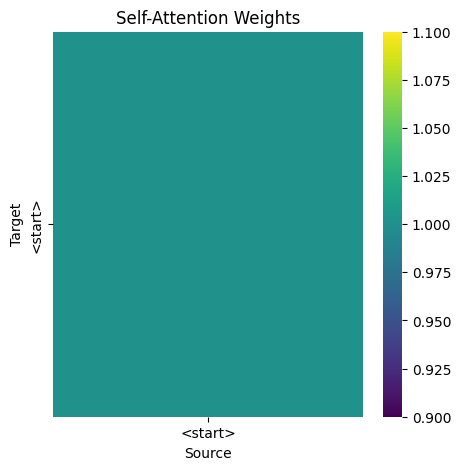

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 16])
multi_attention: 
[[2.2392824e-08 2.6962070e-07 1.7484457e-07 2.6636848e-09 9.9999964e-01
  3.4455421e-11 2.5576492e-11 4.6268675e-13 7.9523418e-16]]
After Attention: tensor([[[ 3.5292,  5.4019, -0.4267,  0.1086,  4.2592,  6.0102, -5.0527, -1.1139, -4.5360, -1.0681,
           4.2836, -0.0165, -4.2285,  1.6838, -6.9477, -2.8424]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


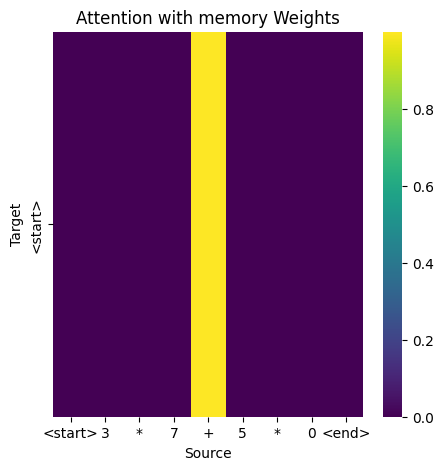

output.shape: torch.Size([1, 16])
output: tensor([[ -6.9228,  -6.5663,  -7.8015,  -8.1797,  -7.3765,  -7.6631,  -6.3330,  -7.3612,  -6.5212,
          -7.0837,   2.8260,  22.6861,  -2.2820, -28.0000,  -2.4362,  -2.3111]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 11

------------------

iter: 1
ys: tensor([[12],
        [11]], device='cuda:0')
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.9632,  0.8501,
           2.6547, -0.6623, -2.2339,  3.3836, -2.5133, -0.4684]]], device='cuda:0')
now tgt: +
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.96

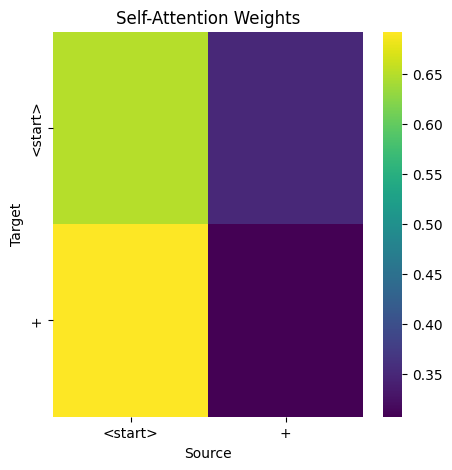

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 16])
multi_attention: 
[[3.4159085e-13 2.5528874e-03 2.0670639e-03 2.7152276e-04 9.9510181e-01
  5.8406890e-06 7.8357925e-07 1.1259366e-08 6.1145650e-12]
 [1.1938675e-13 5.0650883e-01 4.0574342e-01 8.6417913e-02 3.6215625e-04
  9.1957615e-04 4.6579520e-05 1.4527858e-06 3.1595284e-09]]
After Attention: tensor([[[ 3.0496,  5.3492, -0.5572,  0.2198,  4.4010,  6.0512, -5.2020, -1.0441, -4.7601, -0.9220,
           4.3666, -0.0121, -4.1842,  1.8055, -7.0038, -2.7728]],

        [[ 1.8192,  2.5292, -2.3308,  0.7153, -4.2652, -3.5148,  0.2920,  6.4185, -5.7099,  4.0132,
          -2.3336, -0.0218, -7.9027,  6.6415, -4.7034,  2.7501]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


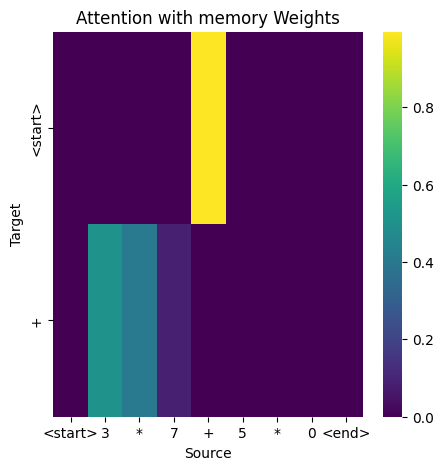

output.shape: torch.Size([1, 16])
output: tensor([[ -9.0610, -16.3449,  -6.3696,   4.4803,  -5.3425,  -5.3398,  -6.7053,  -4.0292,  -4.7960,
          -6.9970,  19.7614,   8.6335,  -7.8712,  -7.6703,  -6.3286,  -3.0249]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 2
ys: tensor([[12],
        [11],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.9632,  0.8501,
           2.6547, -0.6623, -2.2339,  3.3836, -2.5133, -0.4684]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]]], device='cuda:0')
now tgt: +*
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852,

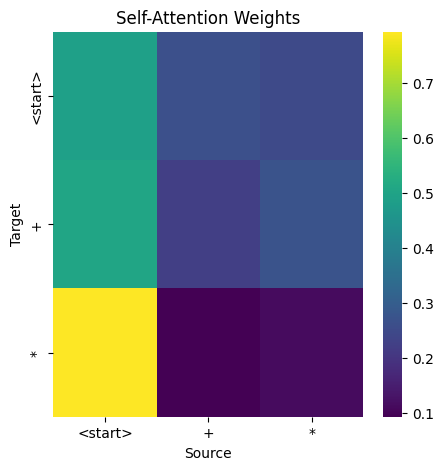

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 16])
multi_attention: 
[[1.7626445e-13 5.6478035e-02 4.8813753e-02 1.5096751e-02 8.7900585e-01
  5.5246643e-04 5.2087114e-05 1.0335580e-06 7.8793216e-10]
 [1.2874772e-14 4.1966239e-01 3.7149617e-01 2.0320700e-01 8.1714381e-05
  5.2988660e-03 2.4277043e-04 1.1061244e-05 3.6678397e-08]
 [2.0237867e-13 7.2455955e-01 6.9580139e-03 2.6055330e-01 3.3066215e-03
  4.6098386e-03 2.3878345e-06 1.0242839e-05 1.1716719e-08]]
After Attention: tensor([[[ 3.0028e+00,  5.4158e+00, -6.0948e-01,  2.4342e-01,  4.2599e+00,  5.9250e+00, -5.1643e+00,
          -7.6406e-01, -5.0106e+00, -7.4879e-01,  4.3117e+00,  3.0973e-03, -4.5095e+00,  2.1247e+00,
          -7.2481e+00, -2.6643e+00]],

        [[ 1.4956e+00,  1.9900e+00, -2.7447e+00,  7.8130e-01, -4.1634e+00, -4.6344e+00, -6.4583e-02,
           7.2460e+00, -4.7438e+00,  3.5963e+00, -1.4376

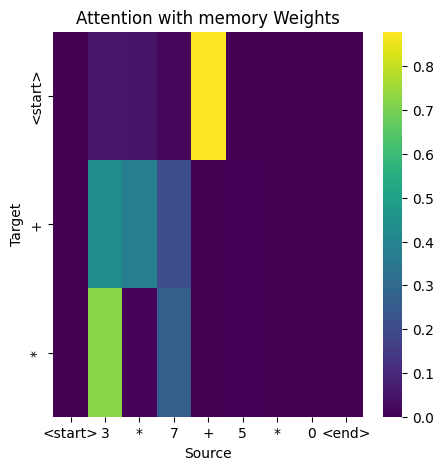

output.shape: torch.Size([1, 16])
output: tensor([[  3.4879,  -1.4991,   9.8451,  20.6611,  10.1298,   9.2690,   7.7798,  13.8130,   9.8302,
           8.2111,   1.7407, -12.2854,  -6.1037,   7.3790,  -4.7138,  -3.3192]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 3

------------------

iter: 3
ys: tensor([[12],
        [11],
        [10],
        [ 3]], device='cuda:0')
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.9632,  0.8501,
           2.6547, -0.6623, -2.2339,  3.3836, -2.5133, -0.4684]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 2.1386, -4.1039, -0.3416, -0.6635, -0.1292, -0.2903, -0.5092,  3.5390, -0.6410,  3.4638,

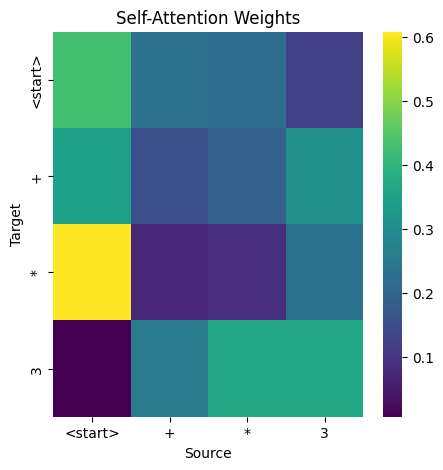

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 16])
multi_attention: 
[[6.7201703e-14 2.5767810e-03 2.9319017e-03 8.2713075e-04 9.9360776e-01
  4.8765563e-05 7.5039611e-06 1.2678879e-07 7.9152726e-11]
 [4.4742747e-14 1.3361952e-01 4.4580171e-01 3.5990468e-01 1.4648217e-05
  5.2210514e-02 7.9624848e-03 4.8266063e-04 3.8167036e-06]
 [4.6002043e-12 3.1604472e-01 2.8629816e-04 6.1792332e-01 6.5262909e-03
  5.8498975e-02 2.8730547e-06 7.1626814e-04 1.2516473e-06]
 [1.0591505e-10 3.6468863e-02 1.5385097e-01 4.7945765e-01 2.5230763e-02
  2.4817161e-01 4.6781328e-02 9.8267477e-03 2.1206170e-04]]
After Attention: tensor([[[ 2.9089e+00,  5.2870e+00, -5.2915e-01,  2.0678e-01,  4.4558e+00,  6.0929e+00, -5.2201e+00,
          -1.0281e+00, -4.7928e+00, -8.9806e-01,  4.4003e+00, -8.0301e-03, -4.1921e+00,  1.8439e+00,
          -7.0093e+00, -2.7463e+00]],

        [[-2.4006e+00,  3.

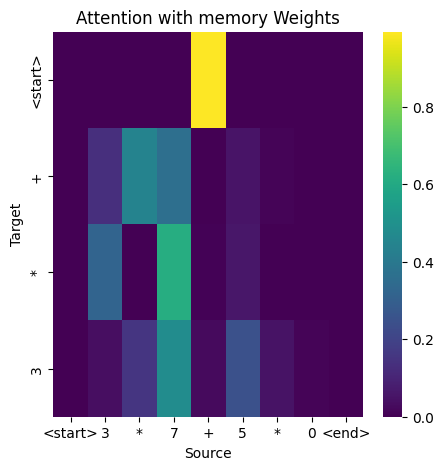

output.shape: torch.Size([1, 16])
output: tensor([[-6.6211,  7.7307,  6.1300, 10.2302,  6.9444, 11.7727,  8.3390, 20.4157, -1.0714,  8.8170,
          9.3169, -6.4321, -8.0855,  2.0279, -4.3892, -1.1510]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 7

------------------

iter: 4
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7]], device='cuda:0')
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.9632,  0.8501,
           2.6547, -0.6623, -2.2339,  3.3836, -2.5133, -0.4684]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 2.1386, -4.1039, -0.3416, -0.6635, -0.1292, -0.2903, -0.5092,  3.5390, -0.6410,  3.4638,
 

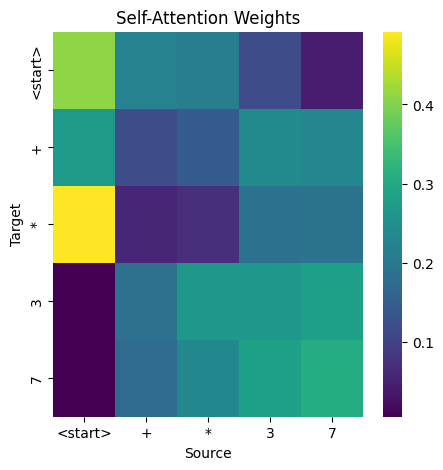

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 16])
multi_attention: 
[[4.5372099e-14 6.6052994e-04 8.2992465e-04 2.2716938e-04 9.9826175e-01
  1.7276392e-05 3.3323595e-06 5.4253245e-08 3.0677686e-11]
 [8.3766194e-09 2.7188036e-04 5.7236198e-03 8.1786448e-03 2.6327155e-07
  1.0767879e-01 5.5084741e-01 2.6088521e-01 6.6414185e-02]
 [6.0486684e-08 1.5557083e-02 3.1936709e-06 2.0622675e-01 4.1756053e-03
  4.7766912e-01 1.6121861e-05 2.9238701e-01 3.9651627e-03]
 [1.3728099e-04 6.7684421e-04 6.9391616e-03 2.4331594e-02 1.4955205e-01
  1.5042609e-01 2.8369439e-01 2.9769191e-01 8.6550683e-02]
 [2.1421029e-04 1.3168524e-04 1.6614861e-03 5.0237556e-03 7.7403024e-02
  8.3361492e-02 3.1442171e-01 4.0490586e-01 1.1287673e-01]]
After Attention: tensor([[[ 2.9051e+00,  5.2657e+00, -5.1562e-01,  1.9680e-01,  4.4655e+00,  6.1107e+00, -5.2256e+00,
          -1.0392e+00, -4.7820e+00,

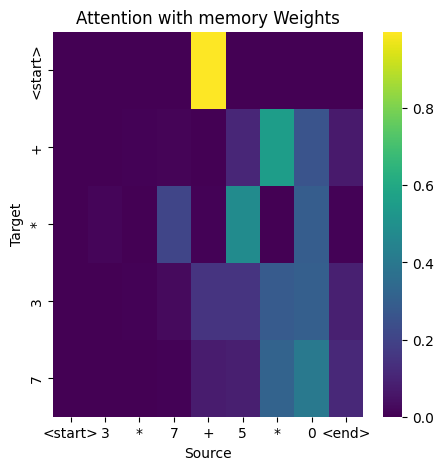

output.shape: torch.Size([1, 16])
output: tensor([[  7.4771,  -7.1095,  -8.3098,  -7.2711,  -6.0369,  -1.2538,  -6.6380, -20.8820,  -6.6721,
          -8.1002,  15.1702,   5.7124,  -1.2616, -13.2494,  -4.4430,  -5.3843]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 5
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.9632,  0.8501,
           2.6547, -0.6623, -2.2339,  3.3836, -2.5133, -0.4684]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 2.1386, -4.1039, -0.3416, -0.6635, -0.1292, -0.2903, -0.509

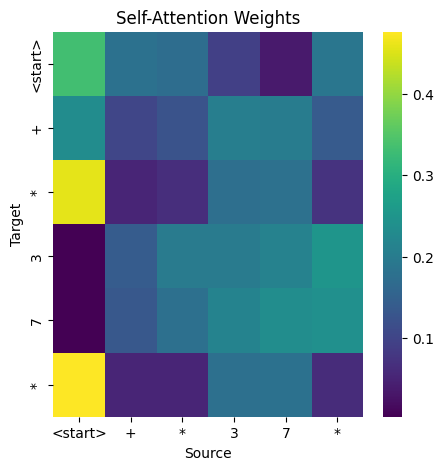

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 16])
multi_attention: 
[[4.1843746e-14 2.3583921e-02 2.2784062e-02 1.2003541e-02 9.4018418e-01
  1.2795791e-03 1.6089232e-04 3.7915477e-06 2.4986440e-09]
 [6.5813864e-14 2.3697903e-02 9.8091789e-02 2.4123456e-01 1.1958050e-06
  4.4063348e-01 1.6613948e-01 2.9690571e-02 5.1103480e-04]
 [8.4628866e-12 3.2259993e-02 1.6304557e-05 3.8547850e-01 4.6979435e-04
  5.2238667e-01 2.3730685e-05 5.9094749e-02 2.7018701e-04]
 [1.3252585e-10 1.6706301e-02 6.0957491e-02 2.9356608e-01 2.7391942e-02
  4.5050678e-01 1.1229240e-01 3.7881251e-02 6.9775886e-04]
 [2.2874490e-10 7.5524650e-03 3.3497870e-02 1.4423220e-01 2.7305400e-02
  4.9307871e-01 2.1136080e-01 8.1616729e-02 1.3558526e-03]
 [9.5257630e-12 4.9281996e-03 4.0357677e-06 8.5418954e-02 4.9926795e-04
  6.8983626e-01 1.0612899e-04 2.1841012e-01 7.9699443e-04]]
After Attention: tenso

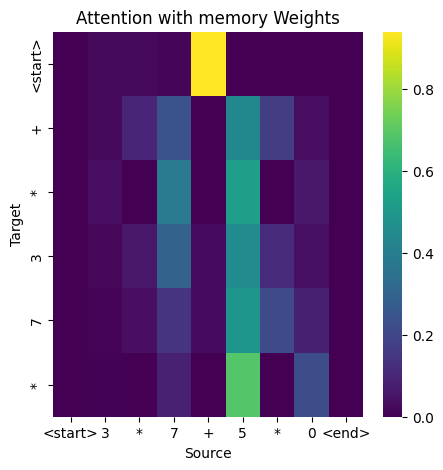

output.shape: torch.Size([1, 16])
output: tensor([[ 13.2865,  11.1831,   5.5442,   9.1349,   8.3358,  21.6238,  10.2954,   3.7250,  -0.8432,
           9.8813,  -2.4945, -15.5435,   1.3899,   5.4350,  -2.1098,  -2.6591]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 6
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7],
        [10],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.9632,  0.8501,
           2.6547, -0.6623, -2.2339,  3.3836, -2.5133, -0.4684]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 2.1386, -4.1039, -0.3416, -0.6635, -0.1292, -0

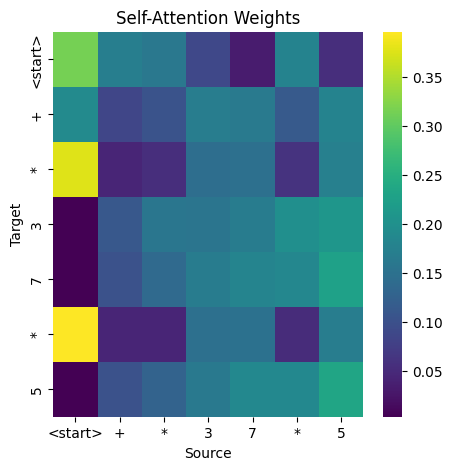

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 16])
multi_attention: 
[[2.59131943e-14 6.55368390e-03 6.87217200e-03 3.51964263e-03
  9.82495904e-01 4.80428658e-04 7.64703000e-05 1.68743952e-06
  1.00709396e-09]
 [3.36454170e-10 6.80407466e-05 7.97393324e-04 2.47416552e-03
  7.62913110e-09 8.10777768e-02 4.44262177e-01 3.38407427e-01
  1.32913083e-01]
 [3.79916045e-08 2.99526902e-04 6.68187923e-08 1.16327852e-02
  2.12979412e-05 1.78786725e-01 1.47144619e-05 7.59790242e-01
  4.94545214e-02]
 [2.86304135e-06 7.07507192e-04 5.11796540e-03 2.66563762e-02
  7.26885051e-02 2.19880432e-01 3.14944953e-01 3.13990980e-01
  4.60104160e-02]
 [4.05229457e-06 1.56773604e-04 1.38963084e-03 5.90910250e-03
  3.74636687e-02 1.24619946e-01 3.56662661e-01 4.17227149e-01
  5.65670505e-02]
 [1.79882438e-08 2.38239081e-05 1.55672613e-08 1.07380573e-03
  1.20884615e-05 8.73974264e-02 4.614

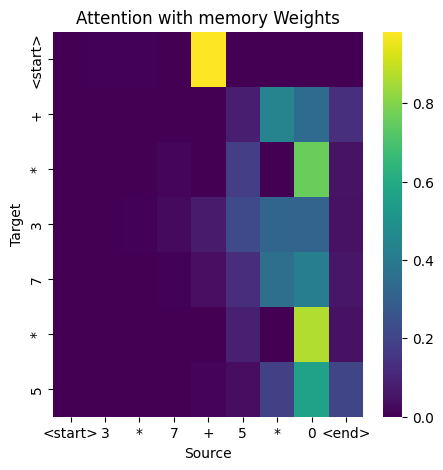

output.shape: torch.Size([1, 16])
output: tensor([[ 18.4684,   3.8144,   3.4038,   3.9778,   5.2921,   8.6625,   4.2034,  -9.4691,   5.3964,
           2.9222,   2.6756, -14.6819,   1.1663,   5.1406,  -2.8411,  -5.5811]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 7
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7],
        [10],
        [ 5],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 0.0517,  2.3375,  1.0709,  1.2143,  0.8672,  4.3604, -1.0538,  1.4102, -1.9632,  0.8501,
           2.6547, -0.6623, -2.2339,  3.3836, -2.5133, -0.4684]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 2.1386, -4.1039, -0.3416, -0.663

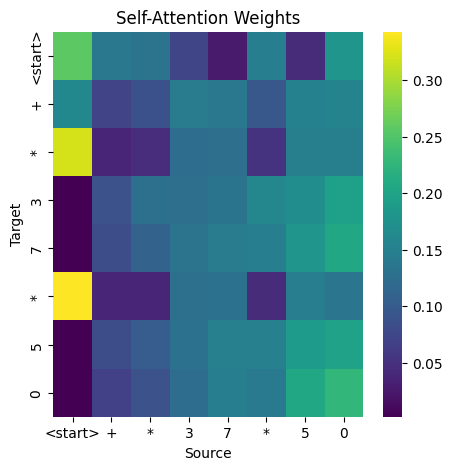

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 16])
multi_attention: 
[[7.3928832e-15 5.0815670e-06 8.7583167e-06 3.5842941e-06 9.9997997e-01
  1.6037263e-06 1.0024710e-06 1.7070228e-08 8.9235563e-12]
 [1.5150136e-04 1.6526010e-07 2.6691528e-06 4.9360497e-06 3.4046282e-10
  4.5303063e-04 2.0228831e-02 6.2693827e-02 9.1646504e-01]
 [3.3366296e-04 4.0128853e-06 2.3629994e-09 1.7106123e-04 1.0573366e-06
  7.1822964e-03 5.7228999e-06 4.4503543e-01 5.4726678e-01]
 [2.2206560e-01 1.4989941e-05 1.5442185e-04 4.9086486e-04 2.2247422e-02
  9.4266990e-03 7.5338900e-02 2.1273443e-01 4.5752662e-01]
 [1.7587413e-01 4.9897371e-06 5.8852016e-05 1.4903602e-04 1.1764065e-02
  6.2364731e-03 8.7030351e-02 2.6360470e-01 4.5527738e-01]
 [4.5944565e-05 8.4812353e-07 1.2986847e-09 4.0318362e-05 1.0596904e-06
  6.7588980e-03 2.3931458e-05 6.0254580e-01 3.9058316e-01]
 [9.4395733e-01 8.52035

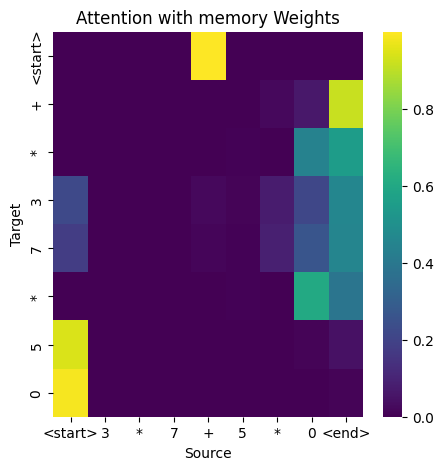

output.shape: torch.Size([1, 16])
output: tensor([[  8.3708,   7.7801,   8.1966,   8.6494,   8.1159,   7.7070,   8.4674,   8.2700,   9.0968,
           8.5725,   3.4365, -21.0629,  -1.7592,  23.1331,  -2.1152,  -1.9307]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 13

------------------

Input: 3*7+5*0
Decoded sequence: +*37*50


In [45]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Attention with memory Weights")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

### MDSを利用

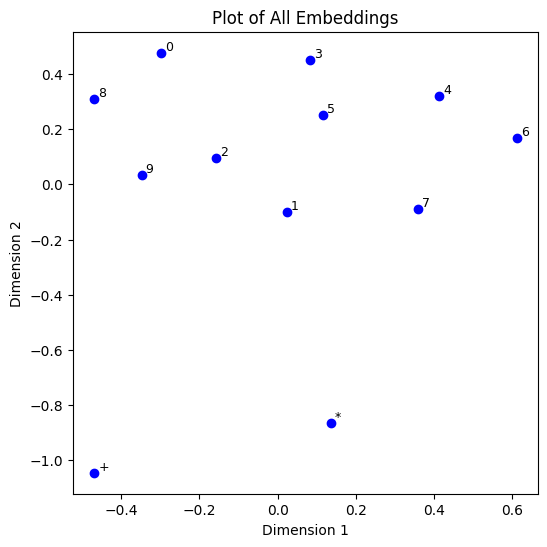

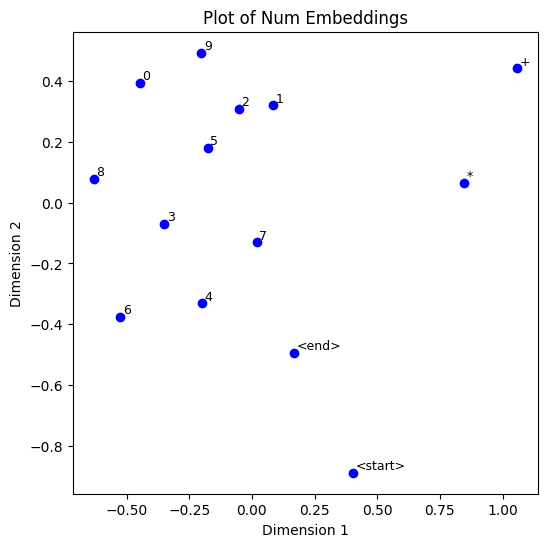

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt

# コサイン類似度に基づいてMDSで2次元に射影する関数
def apply_mds(embedding_weight, n_components=2):
    # コサイン類似度行列の計算
    cosine_sim = cosine_similarity(embedding_weight.cpu().detach().numpy())
    
    # 類似度を距離として扱うために、1 - コサイン類似度に変換
    distance_matrix = 1 - cosine_sim
    
    # MDSを適用して2次元に射影
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    embedding_2d_mds = mds.fit_transform(distance_matrix)
    
    return embedding_2d_mds

# 逆辞書を作成
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

# 2次元に射影された埋め込みベクトルのプロット
def plot_embedding_tgt_2d(embedded_weight, ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))
    embedded_weight = embedded_weight.cpu().detach()

    if tgt_embed is not None:
        # TensorのままMDSを適用する
        tgt_embed = tgt_embed.cpu().detach()
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=1)
        
        # embedded_weightとtgt_embedを結合しMDSを適用
        embed = np.vstack((embedded_weight.numpy(), tgt_embed.numpy()))
        embedded_weight_2d = apply_mds(torch.tensor(embed), n_components=2)
        tgt_embed_2d = embedded_weight_2d[-tgt_embed.shape[0]:]  # 最後のベクトルがターゲット埋め込み
        embedded_weight_2d = embedded_weight_2d[:-tgt_embed.shape[0]]  # 残りはもともとの埋め込み

        # ターゲット埋め込みベクトルをプロット
        for i, (x, y) in enumerate(tgt_embed_2d):
            if tgt_embed.shape[0] == 1:
                label = "Taget"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='red', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, label, fontsize=9)
    else:
        # コサイン類似度に基づくMDSを適用してプロット
        embedded_weight_2d = apply_mds(embedded_weight, n_components=2)

    # MDSで圧縮された埋め込みをプロット
    for i, (x, y) in enumerate(embedded_weight_2d):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


# プロットの実行
plot_embedding_tgt_2d(embedding_weight[:12, :], title="All Embeddings")
plot_embedding_tgt_2d(embedding_weight[:14, :], title="Num Embeddings")


text: 3*7+5*0
memory: tensor([[[ 0.2112,  0.5013,  1.5649,  1.4491, -3.3551,  3.3795,  0.0852, -0.6984,  0.7988, -2.3858,
          -1.1839,  3.9792, -0.9674, -0.6262,  0.6884,  0.8154]],

        [[ 2.8390, -2.5736, -0.8433, -0.2959, -0.3249, -0.2507, -0.5723,  3.5430, -0.6610,  3.4642,
          -2.3003,  1.8959,  1.6865,  1.2695,  0.6713, -1.3146]],

        [[-2.2302,  0.1674, -1.7789,  1.4732, -0.6030, -1.5762, -2.4297,  2.8284, -2.3591,  1.5026,
           0.6018, -0.4515, -2.0257,  1.8944, -1.8369,  4.2743]],

        [[ 0.6692, -3.8707, -0.5416,  0.3585,  0.2717, -2.0209, -1.3933,  4.1658,  1.0289,  0.2632,
           1.6088,  2.1429,  3.6093,  0.9249, -0.6830, -0.8424]],

        [[-1.5465,  1.1436,  1.7135,  0.5650,  1.1568,  4.2865, -0.9592,  1.4028, -1.9332,  0.8494,
           2.6642, -0.6624, -2.2309,  3.3836, -2.5123, -0.4684]],

        [[ 1.0830, -2.1204,  0.4318, -1.6942, -0.9179, -0.3045, -1.5207,  1.1466,  0.8474,  3.6547,
           1.8862,  0.7856,  0.1290, -0.306

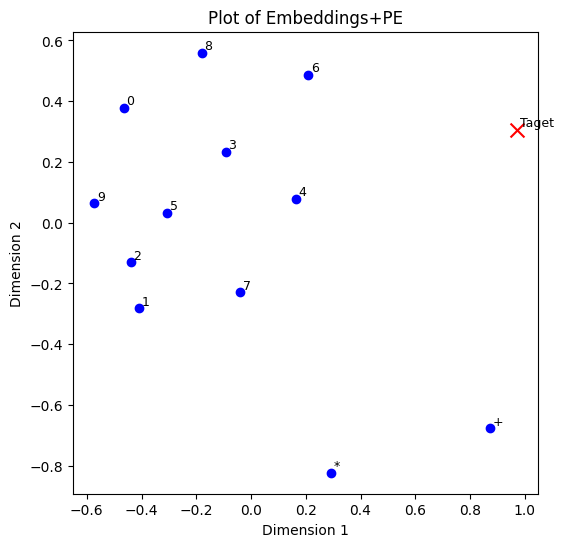

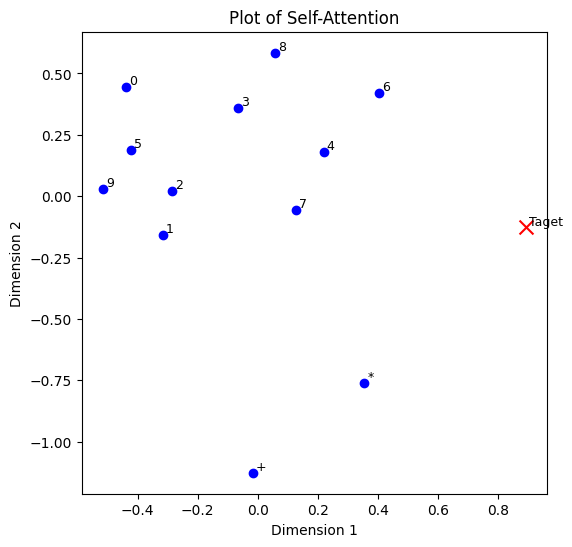

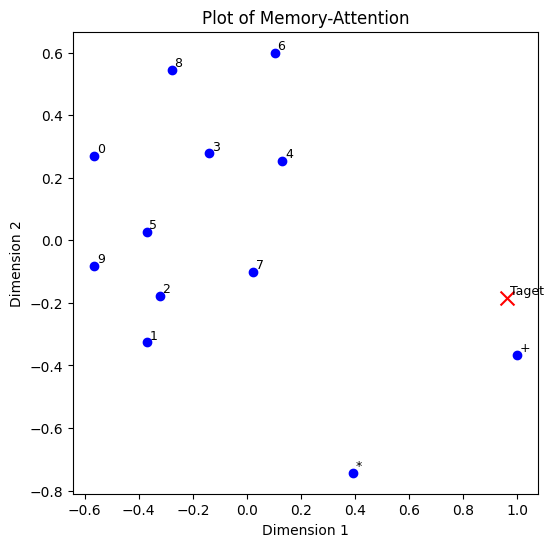

output.shape: torch.Size([1, 16])
output: tensor([[ -6.9228,  -6.5663,  -7.8015,  -8.1797,  -7.3765,  -7.6631,  -6.3330,  -7.3612,  -6.5212,
          -7.0837,   2.8260,  22.6861,  -2.2820, -28.0000,  -2.4362,  -2.3111]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: +

------------------

iter: 1
ys: tensor([[12],
        [11]], device='cuda:0')


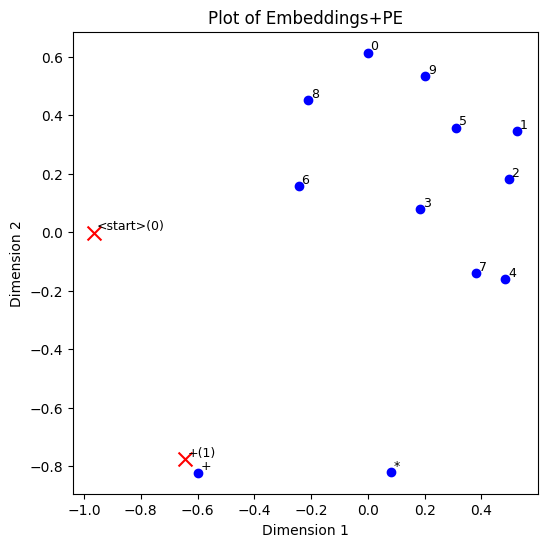

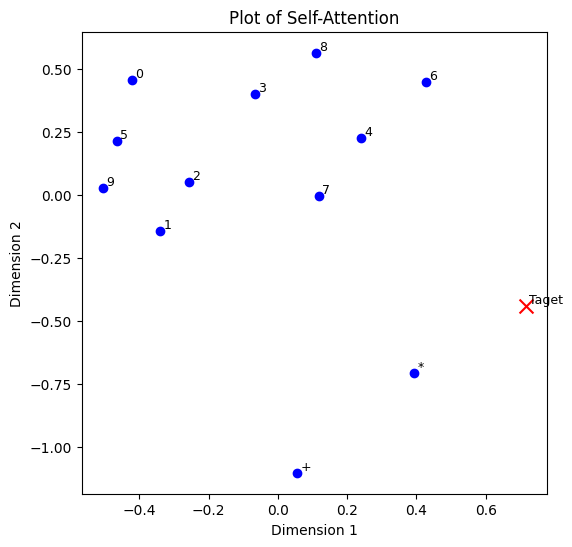

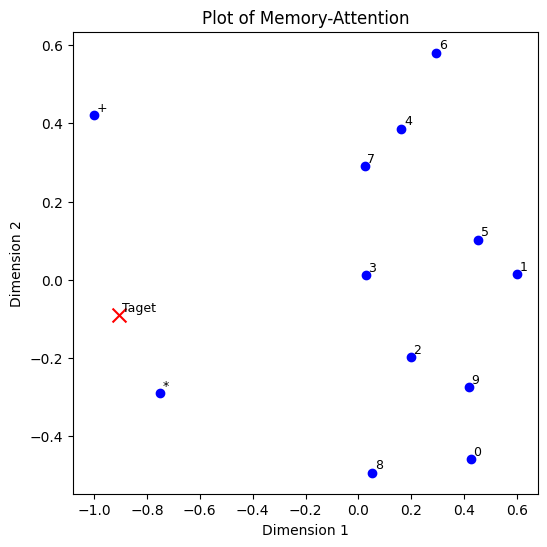

output.shape: torch.Size([1, 16])
output: tensor([[ -9.0610, -16.3449,  -6.3696,   4.4803,  -5.3425,  -5.3398,  -6.7053,  -4.0292,  -4.7960,
          -6.9970,  19.7614,   8.6335,  -7.8712,  -7.6703,  -6.3286,  -3.0249]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: *

------------------

iter: 2
ys: tensor([[12],
        [11],
        [10]], device='cuda:0')


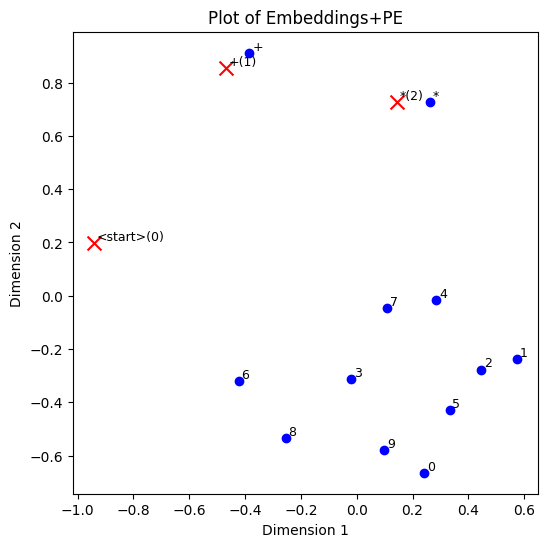

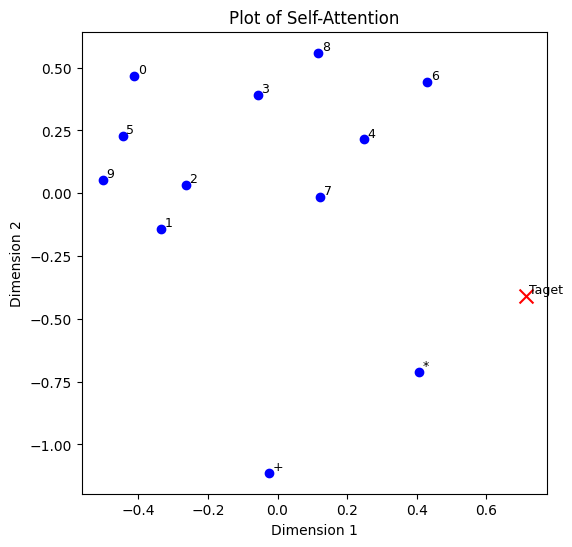

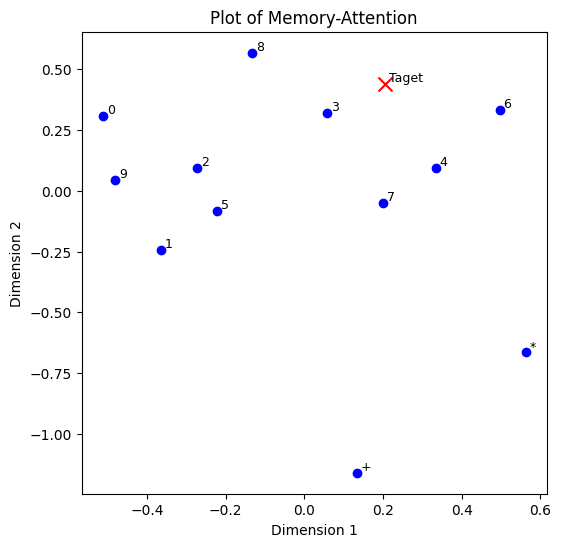

output.shape: torch.Size([1, 16])
output: tensor([[  3.4879,  -1.4991,   9.8451,  20.6611,  10.1298,   9.2690,   7.7798,  13.8130,   9.8302,
           8.2111,   1.7407, -12.2854,  -6.1037,   7.3790,  -4.7138,  -3.3192]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 3

------------------

iter: 3
ys: tensor([[12],
        [11],
        [10],
        [ 3]], device='cuda:0')


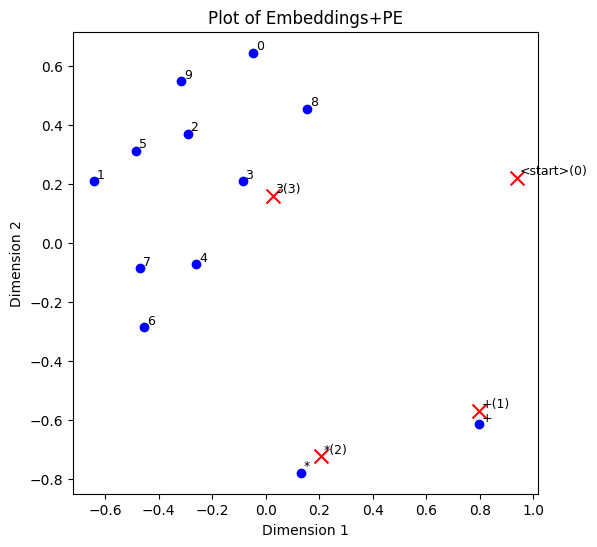

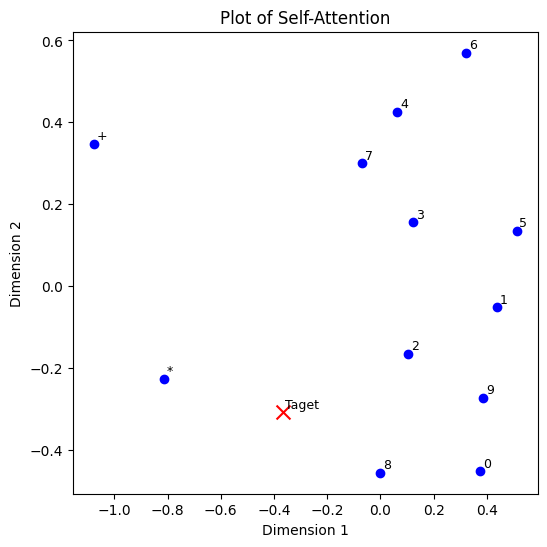

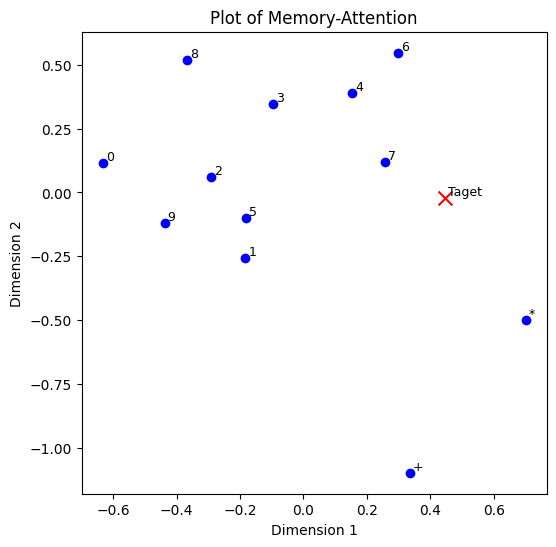

output.shape: torch.Size([1, 16])
output: tensor([[-6.6211,  7.7307,  6.1300, 10.2302,  6.9444, 11.7727,  8.3390, 20.4157, -1.0714,  8.8170,
          9.3169, -6.4321, -8.0855,  2.0279, -4.3892, -1.1510]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 7

------------------

iter: 4
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7]], device='cuda:0')


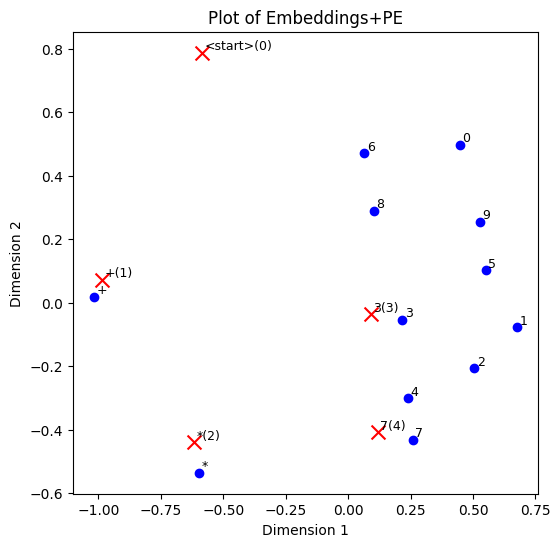

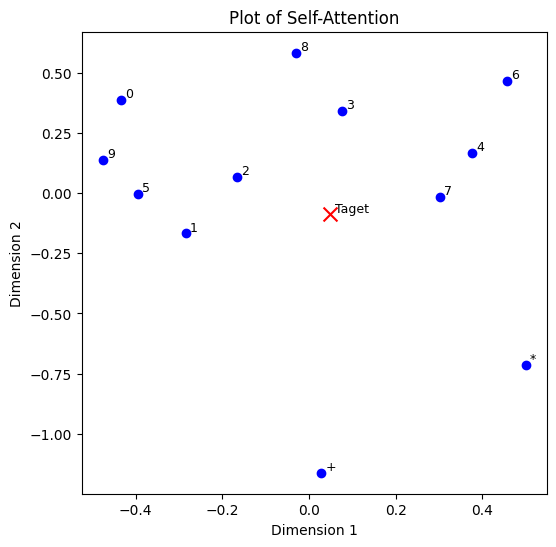

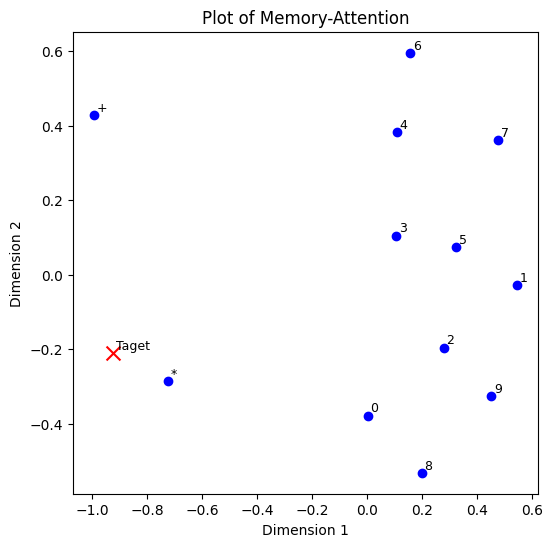

output.shape: torch.Size([1, 16])
output: tensor([[  7.4771,  -7.1095,  -8.3098,  -7.2711,  -6.0369,  -1.2538,  -6.6380, -20.8820,  -6.6721,
          -8.1002,  15.1702,   5.7124,  -1.2616, -13.2494,  -4.4430,  -5.3843]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: *

------------------

iter: 5
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7],
        [10]], device='cuda:0')


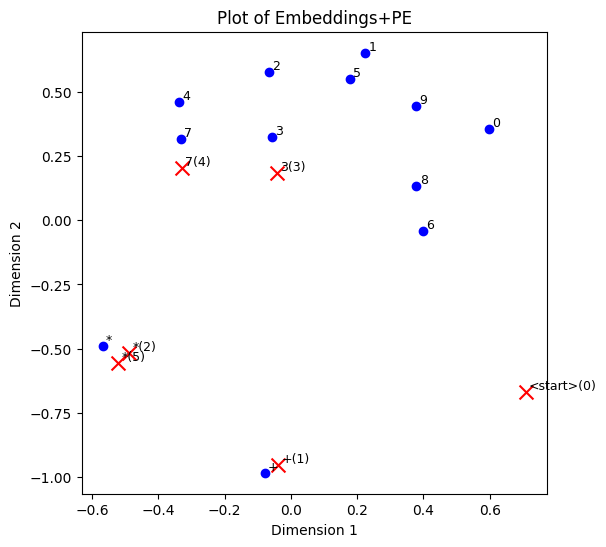

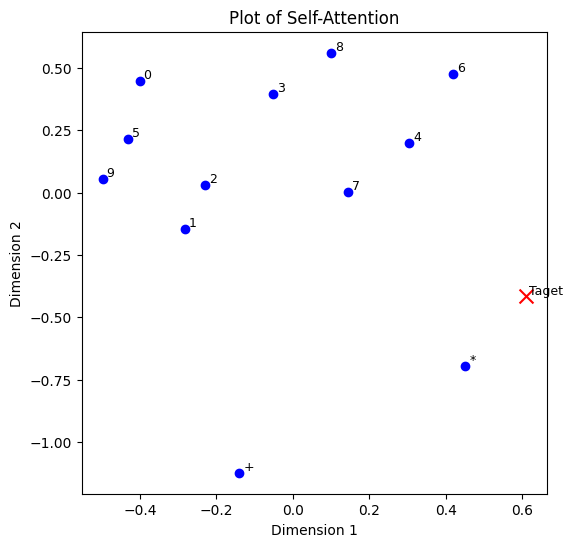

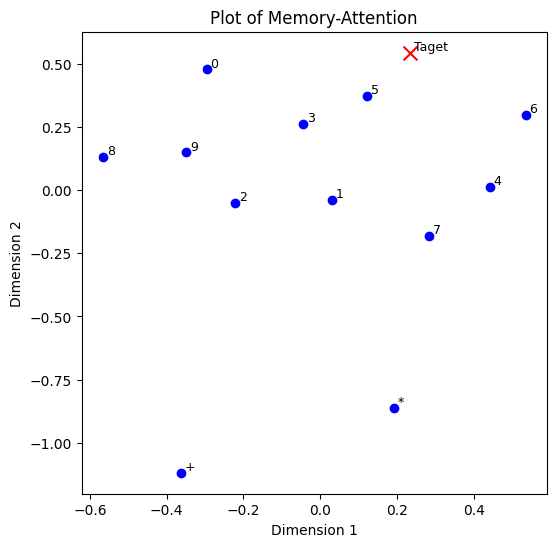

output.shape: torch.Size([1, 16])
output: tensor([[ 13.2865,  11.1831,   5.5442,   9.1349,   8.3358,  21.6238,  10.2954,   3.7250,  -0.8432,
           9.8813,  -2.4945, -15.5435,   1.3899,   5.4350,  -2.1098,  -2.6591]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 6
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7],
        [10],
        [ 5]], device='cuda:0')


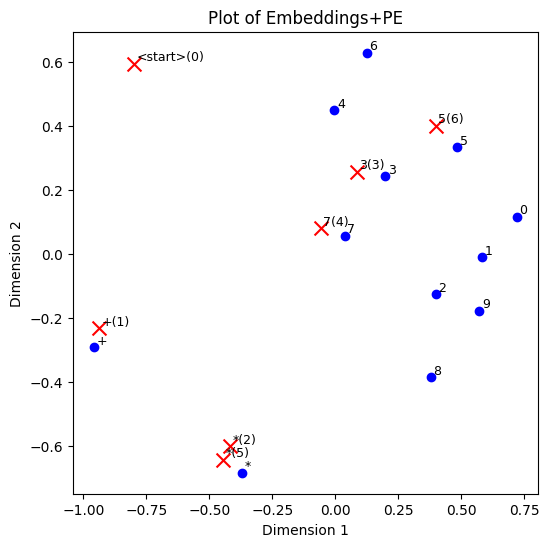

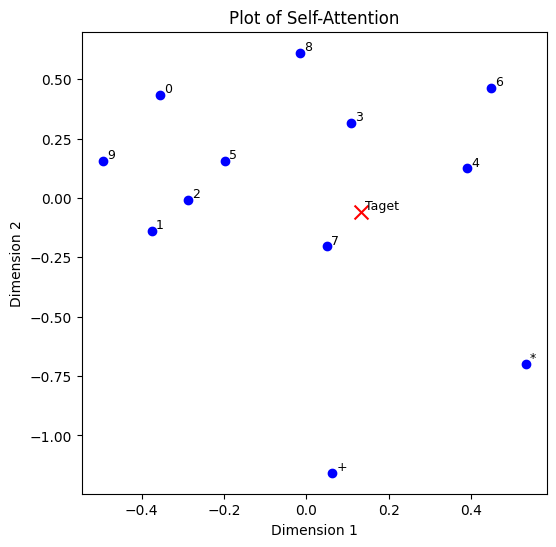

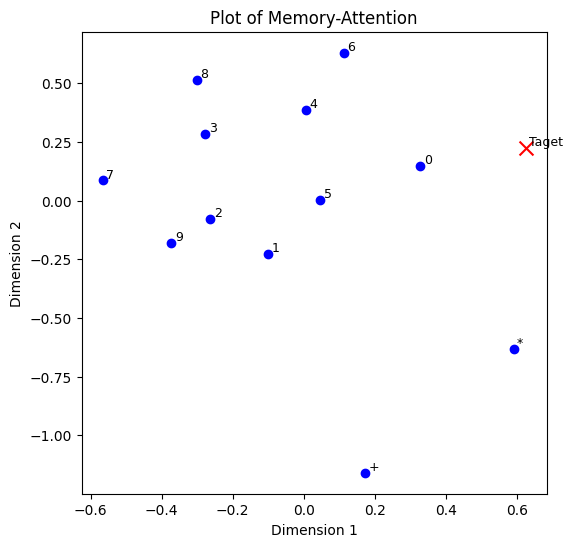

output.shape: torch.Size([1, 16])
output: tensor([[ 18.4684,   3.8144,   3.4038,   3.9778,   5.2921,   8.6625,   4.2034,  -9.4691,   5.3964,
           2.9222,   2.6756, -14.6819,   1.1663,   5.1406,  -2.8411,  -5.5811]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 7
ys: tensor([[12],
        [11],
        [10],
        [ 3],
        [ 7],
        [10],
        [ 5],
        [ 0]], device='cuda:0')


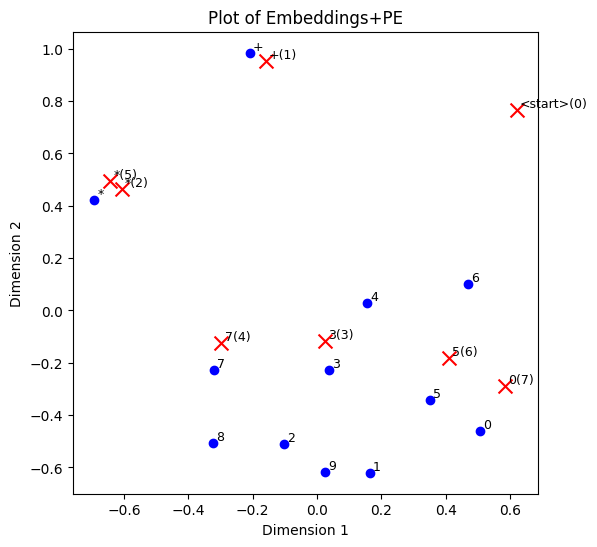

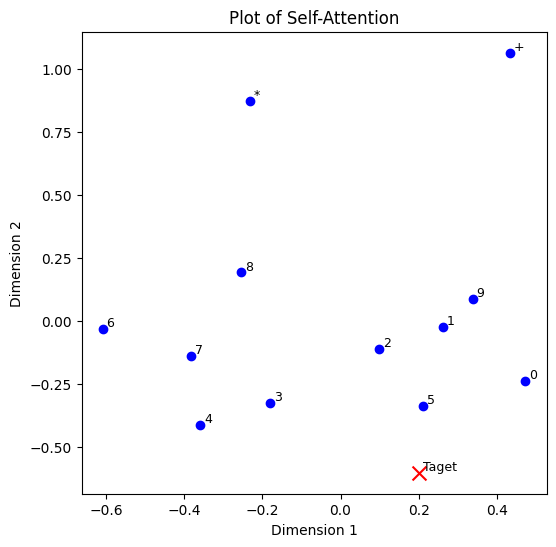

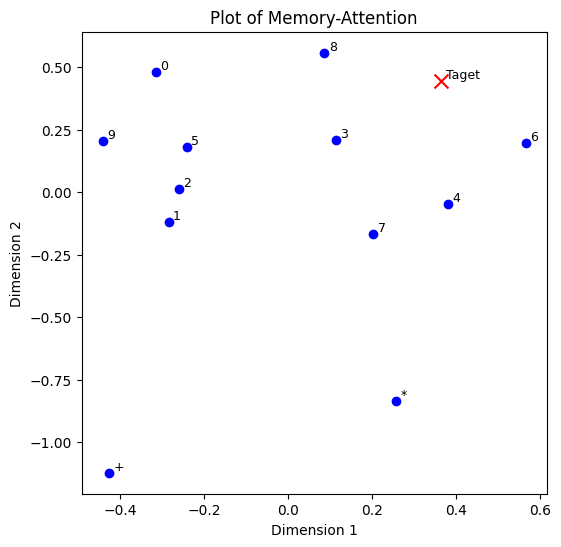

output.shape: torch.Size([1, 16])
output: tensor([[  8.3708,   7.7801,   8.1966,   8.6494,   8.1159,   7.7070,   8.4674,   8.2700,   9.0968,
           8.5725,   3.4365, -21.0629,  -1.7592,  23.1331,  -2.1152,  -1.9307]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 

------------------



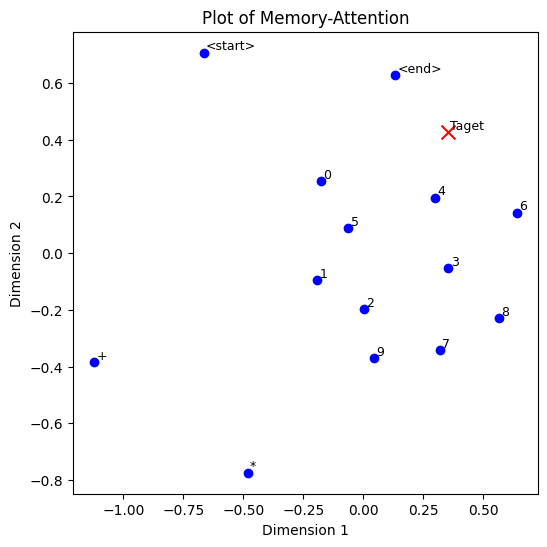

Input: 3*7+5*0
Decoded sequence: +*37*50


In [50]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d ,ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=tgt_embed, title="E+PE")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:12, :], ys=ys, tgt_embed=tgt_embed, title="Embeddings+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:12, :], ys=ys, tgt_embed=tgt[-1:, :], title="Self-Attention")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:12, :], ys=ys, tgt_embed=tgt[-1:, :], title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {convert_indexes_to_text([next_word], vocab_tgt)}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break

# 最後に<end>の埋め込みまで計算
plot_embedding_tgt_2d(embedded_weight=embedding_weight[:14, :], ys=ys, tgt_embed=tgt[-1:, :], src=src, title="Memory-Attention")

flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")